In [1]:
"""
production_ready_autoencoders.py

Run: python production_ready_autoencoders.py
Requires: tensorflow (2.10+ recommended), numpy, matplotlib
"""

import os
import random
import datetime
from typing import Tuple, Optional

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility & GPU
# -------------------------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Configure GPU memory growth if GPUs available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

c:\Users\shoai\anaconda3\envs\aivenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# -------------------------
# Utilities
# -------------------------
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def show_images_grid(images: np.ndarray, ncols: int = 8, title: Optional[str] = None):
    """Display images in a grid. Expects images in [0,1]."""
    n = images.shape[0]
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(ncols * 1.6, nrows * 1.6))
    if title:
        plt.suptitle(title, fontsize=14, fontweight="bold")
    for i in range(n):
        ax = plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# -------------------------
# Dataset (CIFAR-10)
# -------------------------
def load_cifar10(normalize: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load CIFAR-10 and preprocess to float32 in [0,1].
    Returns (x_train, x_test)
    """
    (x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    if normalize:
        x_train /= 255.0
        x_test /= 255.0
    return x_train, x_test

In [3]:
# -------------------------
# Denoising Autoencoder
# -------------------------
class DenoisingAutoencoder:
    def __init__(self, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        self.model: Optional[keras.Model] = None
        self.history = None

    def build(self) -> keras.Model:
        inp = layers.Input(shape=self.input_shape)

        # Encoder
        x = layers.Conv2D(32, 3, activation="relu", padding="same")(inp)
        x = layers.MaxPooling2D(2, padding="same")(x)
        x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
        x = layers.MaxPooling2D(2, padding="same")(x)

        # Decoder
        x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
        x = layers.UpSampling2D(2)(x)
        x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
        x = layers.UpSampling2D(2)(x)
        out = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

        model = keras.Model(inp, out, name="denoising_autoencoder")
        model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mse"])
        self.model = model
        return model

    @staticmethod
    def add_noise(images: np.ndarray, noise_factor: float = 0.15) -> np.ndarray:
        noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
        return np.clip(noisy, 0.0, 1.0)

    def train(
        self,
        x_train: np.ndarray,
        x_val: np.ndarray,
        noise_factor: float = 0.15,
        epochs: int = 20,
        batch_size: int = 128,
        model_dir: str = "models/denoiser",
    ):
        if self.model is None:
            self.build()

        ensure_dir(model_dir)

        x_train_noisy = self.add_noise(x_train, noise_factor)
        x_val_noisy = self.add_noise(x_val, noise_factor)

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                os.path.join(model_dir, "denoiser_best.keras"),
                save_best_only=True,
                monitor="val_loss"
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
        ]

        self.history = self.model.fit(
            x=x_train_noisy,
            y=x_train,
            validation_data=(x_val_noisy, x_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=2,
        )
        # Save final model
        self.model.save(os.path.join(model_dir, "denoiser_final.keras"))
        return self.history

    def denoise(self, noisy_images: np.ndarray) -> np.ndarray:
        assert self.model is not None, "Model not built/trained"
        return self.model.predict(noisy_images, verbose=0)

    def plot_history(self):
        if self.history is None:
            print("No history available")
            return
        plt.figure(figsize=(8, 4))
        plt.plot(self.history.history["loss"], label="train_loss")
        plt.plot(self.history.history["val_loss"], label="val_loss")
        plt.title("Denoising Autoencoder Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [4]:
# -------------------------
# VAE Components
# -------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
    """
    VAE implemented as a keras.Model subclass.
    Use 'beta' to weight KL term. 'beta' can be updated externally (annealing).
    """

    def __init__(self, encoder: keras.Model, decoder: keras.Model, beta: float = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(float(beta), trainable=False, dtype=tf.float32)

        # metrics
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # Reconstruction loss - MSE per pixel
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction),
                    axis=[1, 2, 3]
                )
            )

            # KL divergence per instance
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction),
                axis=[1, 2, 3]
            )
        )

        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        total_loss = reconstruction_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [5]:
# -------------------------
# VAE Builder & Training
# -------------------------
def build_encoder(input_shape=(32, 32, 3), latent_dim=32) -> keras.Model:
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder


def build_decoder(output_shape=(32, 32, 3), latent_dim=32) -> keras.Model:
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2DTranspose(output_shape[2], 3, padding="same", activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")
    return decoder


class KLAnnealingCallback(keras.callbacks.Callback):
    """
    Anneal beta from start_beta -> target_beta over 'warmup_epochs' using linear schedule.
    """

    def __init__(self, warmup_epochs=10, start_beta=0.0, target_beta=1.0):
        super().__init__()
        self.warmup_epochs = warmup_epochs
        self.start_beta = float(start_beta)
        self.target_beta = float(target_beta)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= self.warmup_epochs:
            beta = self.target_beta
        else:
            # linear interpolation
            beta = self.start_beta + (self.target_beta - self.start_beta) * (epoch / max(1, self.warmup_epochs))

        # set beta on model
        if hasattr(self.model, "beta"):
            self.model.beta.assign(float(beta))
            print(f"Epoch {epoch + 1}: beta = {beta:.4f}")


def train_vae(
    x_train: np.ndarray,
    x_val: np.ndarray,
    latent_dim: int = 32,
    epochs: int = 30,
    batch_size: int = 128,
    model_dir: str = "models/vae",
    kl_warmup_epochs: int = 10,
    target_beta: float = 1.0,
):
    ensure_dir(model_dir)

    # Build encoder + decoder
    encoder = build_encoder(latent_dim=latent_dim)
    decoder = build_decoder(latent_dim=latent_dim)

    # Build VAE model
    vae = VAE(encoder, decoder, beta=0.0)
    vae.compile(optimizer=keras.optimizers.Adam(1e-3))

    # Build the model by doing one forward pass
    _ = vae(x_train[:1])

    # Callbacks
    callbacks = [
        KLAnnealingCallback(
            warmup_epochs=kl_warmup_epochs,
            start_beta=0.0,
            target_beta=target_beta,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            min_lr=1e-6,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=12,
            restore_best_weights=True,
        ),
    ]

    # Train VAE
    history = vae.fit(
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, x_val),
        callbacks=callbacks,
        verbose=2,
    )

    # Save models
    vae.save_weights(os.path.join(model_dir, "vae_weights_final.weights.h5"))
    encoder.save(os.path.join(model_dir, "encoder.keras"))
    decoder.save(os.path.join(model_dir, "decoder.keras"))

    return vae, history

In [6]:
# -------------------------
# Visualization helpers for VAE & Denoiser
# -------------------------
def visualize_denoiser(denoiser: DenoisingAutoencoder, x_test: np.ndarray, noise_factor: float = 0.15, n: int = 10):
    x_test_noisy = denoiser.add_noise(x_test, noise_factor)[:n]
    denoised = denoiser.denoise(x_test_noisy)

    plt.figure(figsize=(12, 4))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=10)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_test_noisy[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Noisy", fontsize=10)

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(np.clip(denoised[i], 0, 1))
        plt.axis("off")
        if i == 0:
            plt.ylabel("Denoised", fontsize=10)

    plt.suptitle("Denoising Autoencoder Results", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


def visualize_vae_reconstructions(encoder: keras.Model, decoder: keras.Model, x_test: np.ndarray, n: int = 10):
    z_mean, z_log_var, z = encoder.predict(x_test[:n], verbose=0)
    reconstructed = decoder.predict(z, verbose=0)

    plt.figure(figsize=(12, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=10)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.clip(reconstructed[i], 0, 1))
        plt.axis("off")
        if i == 0:
            plt.ylabel("Reconstructed", fontsize=10)

    plt.suptitle("VAE Reconstruction Results", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


def generate_new_images(decoder: keras.Model, latent_dim: int = 32, n: int = 16):
    """Generate new images by sampling from latent space"""
    random_latent = np.random.normal(size=(n, latent_dim))
    generated = decoder.predict(random_latent, verbose=0)

    plt.figure(figsize=(8, 8))
    for i in range(n):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(np.clip(generated[i], 0, 1))
        plt.axis("off")
    plt.suptitle("VAE Generated Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

Production-Ready Autoencoders for CIFAR-10

[1/5] Loading CIFAR-10 dataset...
Training shape: (50000, 32, 32, 3), Test shape: (10000, 32, 32, 3)


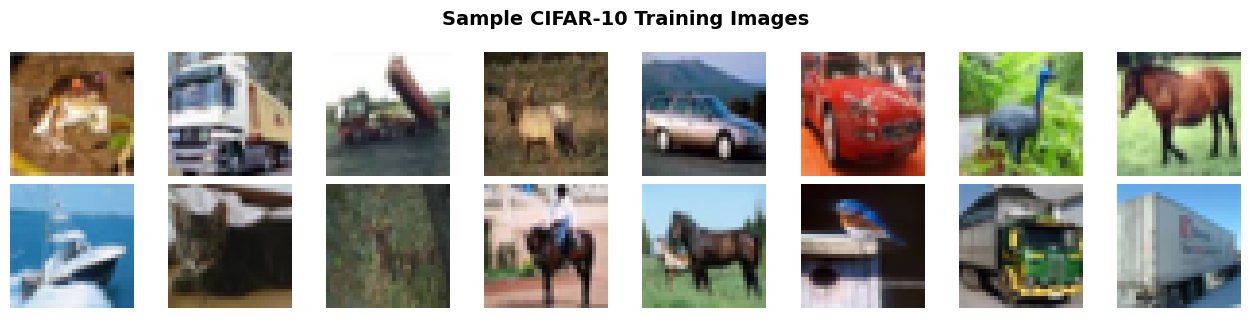


[2/5] Training Denoising Autoencoder...


Model: "denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
391/391 - 55s - 140ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0074 - val_mse: 0.0074 - learning_rate: 1.0000e-03
Epoch 2/20
391/391 - 56s - 144ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0062 - val_mse: 0.0062 - learning_rate: 1.0000e-03
Epoch 3/20
391/391 - 52s - 133ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0057 - val_mse: 0.0057 - learning_rate: 1.0000e-03
Epoch 4/20
391/391 - 76s - 193ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0053 - val_mse: 0.0053 - learning_rate: 1.0000e-03
Epoch 5/20
391/391 - 80s - 204ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0052 - val_mse: 0.0052 - learning_rate: 1.0000e-03
Epoch 6/20
391/391 - 57s - 145ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0050 - val_mse: 0.0050 - learning_rate: 1.0000e-03
Epoch 7/20
391/391 - 62s - 158ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0048 - val_mse: 0.0048 - learning_rate: 1.0000e-03
Epoch 8/20
391/391 - 73s - 188ms/step - loss: 0.0048 - mse: 0.0048 - va

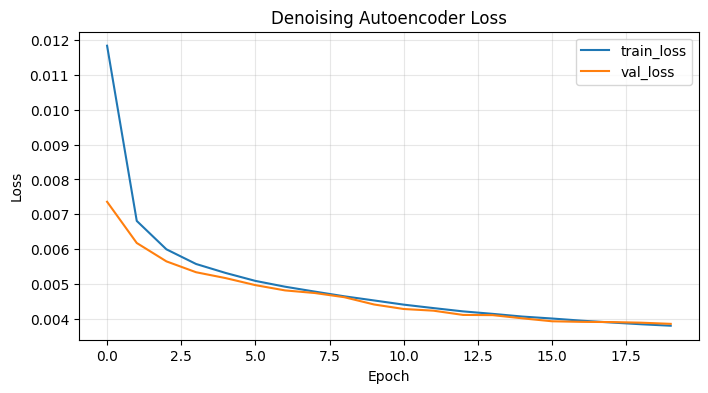

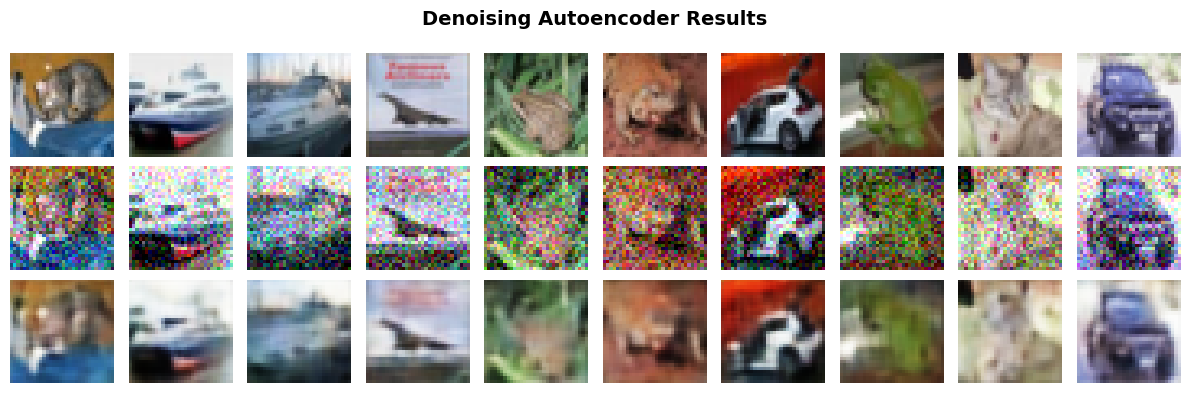


[4/5] Training Variational Autoencoder (VAE)...

Epoch 1: beta = 0.0000
Epoch 1/30
391/391 - 54s - 138ms/step - kl_loss: 140.7755 - loss: 103.7558 - reconstruction_loss: 103.7558 - val_kl_loss: 207.6151 - val_loss: 58.3001 - val_reconstruction_loss: 58.3001 - learning_rate: 1.0000e-03
Epoch 2: beta = 0.1000
Epoch 2/30
391/391 - 55s - 141ms/step - kl_loss: 68.2165 - loss: 60.1706 - reconstruction_loss: 53.3489 - val_kl_loss: 64.5021 - val_loss: 55.7372 - val_reconstruction_loss: 49.2870 - learning_rate: 1.0000e-03
Epoch 3: beta = 0.2000
Epoch 3/30
391/391 - 70s - 179ms/step - kl_loss: 52.5323 - loss: 58.8143 - reconstruction_loss: 48.3078 - val_kl_loss: 52.3964 - val_loss: 57.2648 - val_reconstruction_loss: 46.7856 - learning_rate: 1.0000e-03
Epoch 4: beta = 0.3000
Epoch 4/30
391/391 - 61s - 155ms/step - kl_loss: 44.2175 - loss: 60.3532 - reconstruction_loss: 47.0879 - val_kl_loss: 44.3167 - val_loss: 59.3269 - val_reconstruction_loss: 46.0319 - learning_rate: 1.0000e-03
Epoch 5: beta 

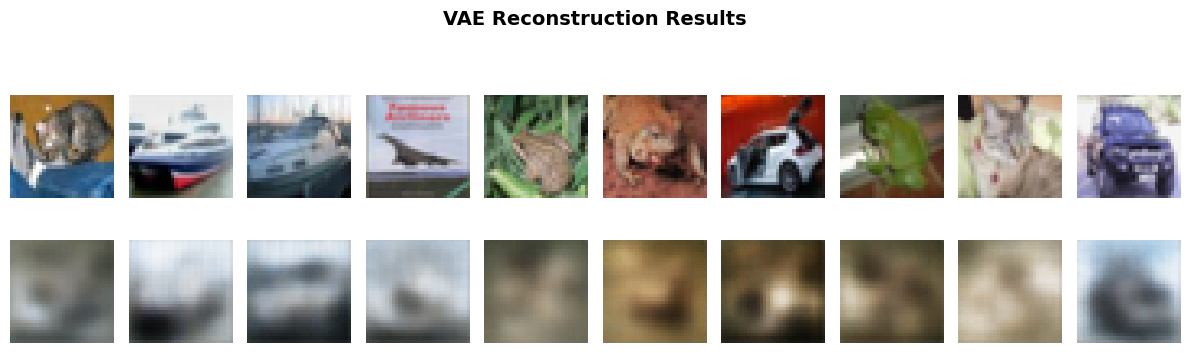

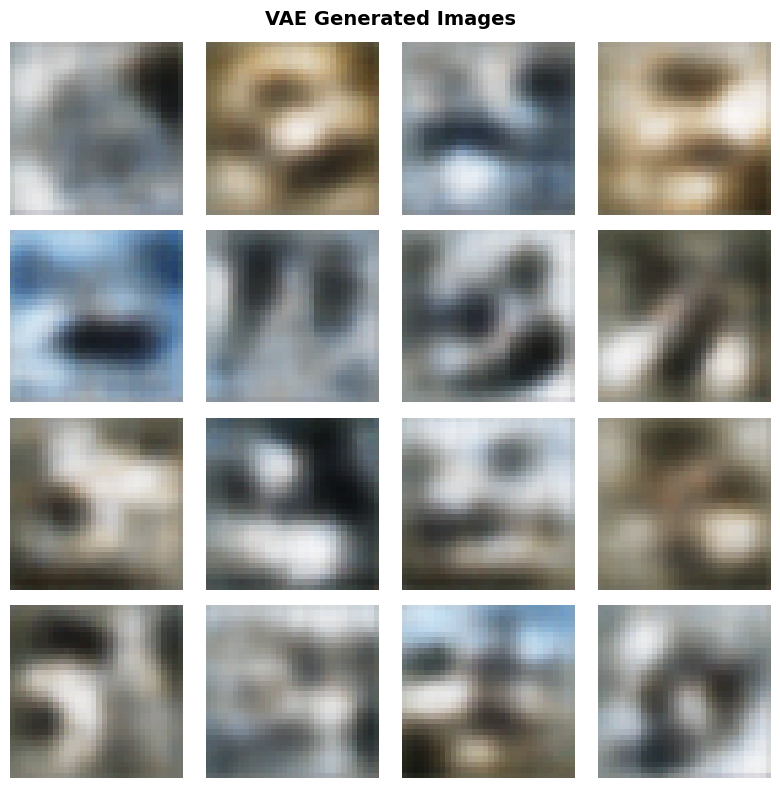

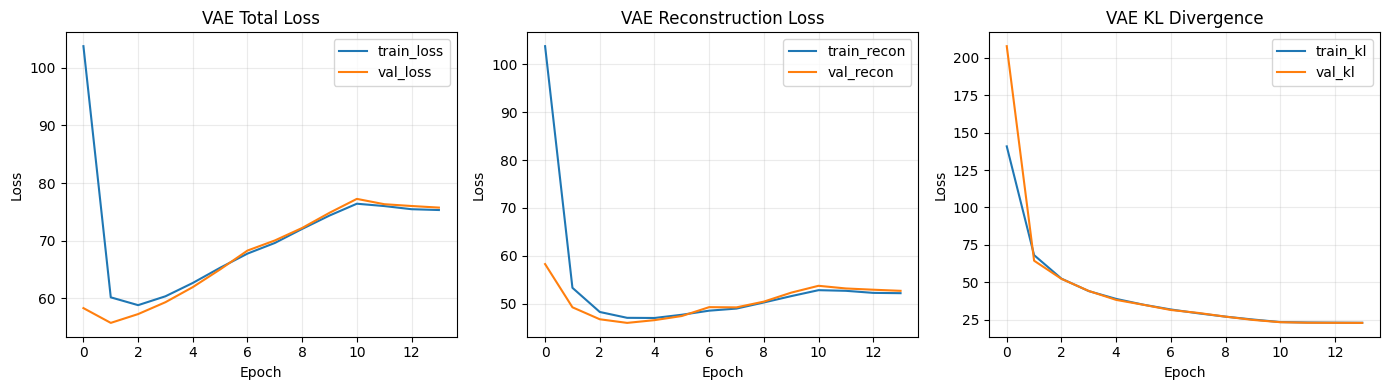


✓ Training complete! Models saved in: models


In [7]:
# -------------------------
# Main runnable flow
# -------------------------
def main():
    print("="*60)
    print("Production-Ready Autoencoders for CIFAR-10")
    print("="*60)

    # Hyperparams
    denoiser_epochs = 20
    vae_epochs = 30
    batch_size = 128
    latent_dim = 32
    model_dir = "models"
    ensure_dir(model_dir)

    # Load dataset
    print("\n[1/5] Loading CIFAR-10 dataset...")
    x_train, x_test = load_cifar10()
    print(f"Training shape: {x_train.shape}, Test shape: {x_test.shape}")

    # Quick visual sanity check
    show_images_grid(x_train[:16], ncols=8, title="Sample CIFAR-10 Training Images")

    # Train denoising autoencoder
    print("\n[2/5] Training Denoising Autoencoder...")
    denoiser = DenoisingAutoencoder()
    denoiser.build()
    print(denoiser.model.summary())

    denoiser.train(
        x_train=x_train,
        x_val=x_test,
        noise_factor=0.15,
        epochs=denoiser_epochs,
        batch_size=batch_size,
        model_dir=os.path.join(model_dir, "denoiser"),
    )

    print("\n[3/5] Visualizing Denoising Results...")
    denoiser.plot_history()
    visualize_denoiser(denoiser, x_test, noise_factor=0.15, n=10)

    # Train VAE
    print("\n[4/5] Training Variational Autoencoder (VAE)...")
    vae, vae_history = train_vae(
        x_train=x_train,
        x_val=x_test,
        latent_dim=latent_dim,
        epochs=vae_epochs,
        batch_size=batch_size,
        model_dir=os.path.join(model_dir, "vae"),
        kl_warmup_epochs=10,
        target_beta=1.0,
    )

    # Visualize VAE results
    print("\n[5/5] Visualizing VAE Results...")
    visualize_vae_reconstructions(vae.encoder, vae.decoder, x_test, n=10)
    generate_new_images(vae.decoder, latent_dim=latent_dim, n=16)

    # Plot VAE training history
    if vae_history is not None:
        h = vae_history.history
        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(h["loss"], label="train_loss")
        if "val_loss" in h:
            plt.plot(h["val_loss"], label="val_loss")
        plt.title("VAE Total Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(alpha=0.25)

        plt.subplot(1, 3, 2)
        if "reconstruction_loss" in h:
            plt.plot(h["reconstruction_loss"], label="train_recon")
        if "val_reconstruction_loss" in h:
            plt.plot(h["val_reconstruction_loss"], label="val_recon")
        plt.title("VAE Reconstruction Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(alpha=0.25)

        plt.subplot(1, 3, 3)
        if "kl_loss" in h:
            plt.plot(h["kl_loss"], label="train_kl")
        if "val_kl_loss" in h:
            plt.plot(h["val_kl_loss"], label="val_kl")
        plt.title("VAE KL Divergence")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(alpha=0.25)

        plt.tight_layout()
        plt.show()

    print("\n" + "="*60)
    print(f"✓ Training complete! Models saved in: {model_dir}")
    print("="*60)


if __name__ == "__main__":
    main()